# Analiza eksploracyjna zbioru `used_cars_2`.

Celem notatnika jest przeprowadzenie analizy eksploracyjnej zbioru used_cars_2 oraz zformułowanie tezy / zadania badawczego prowadzącego do budowy modelu regresji przewidującego `price` (cenę auta) na podstawie cech opisowych.


In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ustawienia wyświetlania
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)


In [120]:
# 1) Wczytanie danych
df = pd.read_csv('used_cars_2.csv')
df.shape, df.columns


((10000, 12),
 Index(['make_year', 'mileage_kmpl', 'engine_cc', 'fuel_type', 'owner_count', 'price_usd', 'brand', 'transmission', 'color',
        'service_history', 'accidents_reported', 'insurance_valid'],
       dtype='object'))

## 1. Przegląd danych

Sprawdzamy przykładowe wiersze, typy danych i ogólną strukturę tabeli.


In [123]:
df.head(3)

,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,color,service_history,accidents_reported,insurance_valid
0,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,White,NaN,0,No
1,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,Black,NaN,0,Yes
2,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,Black,Full,1,Yes


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     7962 non-null   object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB


Zbiór posiada 10000 obserwacji. Możemy zauważyć, że jest on uporządkowany, a kategorie numeryczne są o numerycznych typach, co zaoszczędzi nam czyszczenia tych kolumn. Jedyne, co rzuca się w oczy to braki w kolumnie service_history.


## 2. Stopień wypełnienia danych (missingness)

**Stopień wypełnienia danych** opisuje, jaka część obserwacji w danej kolumnie ma realną wartość (a nie brak `NaN`).  
Formalnie można go liczyć np. jako:

- `wypełnienie = 1 - (liczba braków / liczba rekordów)`

To ważne, bo braki danych wpływają na dalsze wnioski i na przygotowanie danych do modelu (np. imputacja lub osobna kategoria `Unknown`).


In [129]:
n = len(df)
missing = pd.DataFrame({
    'missing': df.isna().sum(),
    'missing_%': (df.isna().sum() / n * 100).round(2),
    'filled_%': (100 - (df.isna().sum() / n * 100)).round(2),
})
missing.sort_values('missing_%', ascending=False)


,missing,missing_%,filled_%
service_history,2038,20.38,79.62
make_year,0,0.00,100.00
mileage_kmpl,0,0.00,100.00
engine_cc,0,0.00,100.00
fuel_type,0,0.00,100.00
owner_count,0,0.00,100.00
price_usd,0,0.00,100.00
brand,0,0.00,100.00
transmission,0,0.00,100.00
color,0,0.00,100.00


W tabeli widać, że zbiór jest ogólnie bardzo dobrze uzupełniony – 11 z 12 kolumn ma 100% wypełnienia (brak wartości NaN). Braki pojawiają się tylko w jednej cesze: *service_history* (2038 braków, 20.38%). Oznacza to, że większość analiz i wizualizacji można wykonywać bez problemu, ale przy budowie modelu regresji trzeba świadomie obsłużyć tą kolumnę (np. przez imputację lub wprowadzenie kategorii „Unknown”), żeby nie tracić dużej liczby rekordów.

## 3. Obsłużenie braków w kolumnie *service_history*



In [133]:
# Zastępujemy braki w historii serwisowej wartością "unknown"
df['service_history'] = df['service_history'].fillna('unknown')

## 4. Normalizacja kategorii

- W kolumnach brand, fuel_type czy transmission mogą być literówki lub różne wielkości liter (np. "Petrol" i "petrol").
- Weryfikacja czy w kolumnach numerycznych nie ma zer, które logicznie nie mają sensu (np. auto z silnikiem 0cc).

In [136]:
# Lista kolumn tekstowych
text_cols = ['fuel_type', 'brand', 'transmission', 'color', 'insurance_valid', 'service_history']

# Usuwamy spacje z brzegów i zamieniamy na małe litery
for col in text_cols:
    df[col] = df[col].str.strip().str.lower()

# Sprawdzamy statystyki opisowe dla kolumn numerycznych
print(df[['mileage_kmpl', 'engine_cc', 'price_usd', 'owner_count']].describe().loc['min'])

# Przy analizie danych okazało się, że warto zlogarytmizować cenę
df['log_price'] = np.log1p(df['price_usd'])

mileage_kmpl       5.0
engine_cc        800.0
price_usd       1000.0
owner_count        1.0
Name: min, dtype: float64


Jak widać powyżej, w kolumnach numerycznych nie ma zer, zbiór ten jest wysokiej jakości i nie wymaga wielu modyfikacji.

## 5. Statystyki opisowe: zakres i zmienność

Dla zmiennych numerycznych sprawdzamy: minimum, kwartyle, medianę, maksimum i odchylenie standardowe.  
To pozwala ocenić:

- **zakres** (jak bardzo wartości się rozciągają),
- **zmienność** (czy dane są skupione czy „rozlane”),
- potencjalne **odstające obserwacje** (outliery).


In [140]:
num_cols = ['mileage_kmpl', 'engine_cc', 'price_usd', 'owner_count', 'log_price']
df[num_cols].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).T


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
mileage_kmpl,10000.0,17.960753,5.025486,5.000000,6.159500,9.580000,11.479000,14.540000,17.970000,21.352500,24.390000,26.400500,29.480800,35.000000
engine_cc,10000.0,2287.130000,1291.276927,800.000000,800.000000,800.000000,1000.000000,1200.000000,1800.000000,3000.000000,5000.000000,5000.000000,5000.000000,5000.000000
price_usd,10000.0,7179.754532,2795.270940,1000.000000,1443.012000,2905.172500,3706.723000,5176.547500,6961.260000,8993.732500,10983.173000,12177.891000,14149.433400,17647.630000
owner_count,10000.0,3.003500,1.418904,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000
log_price,10000.0,8.790516,0.450723,6.908755,7.275181,7.974592,8.218173,8.552087,8.848259,9.104394,9.304211,9.407459,9.557501,9.778413


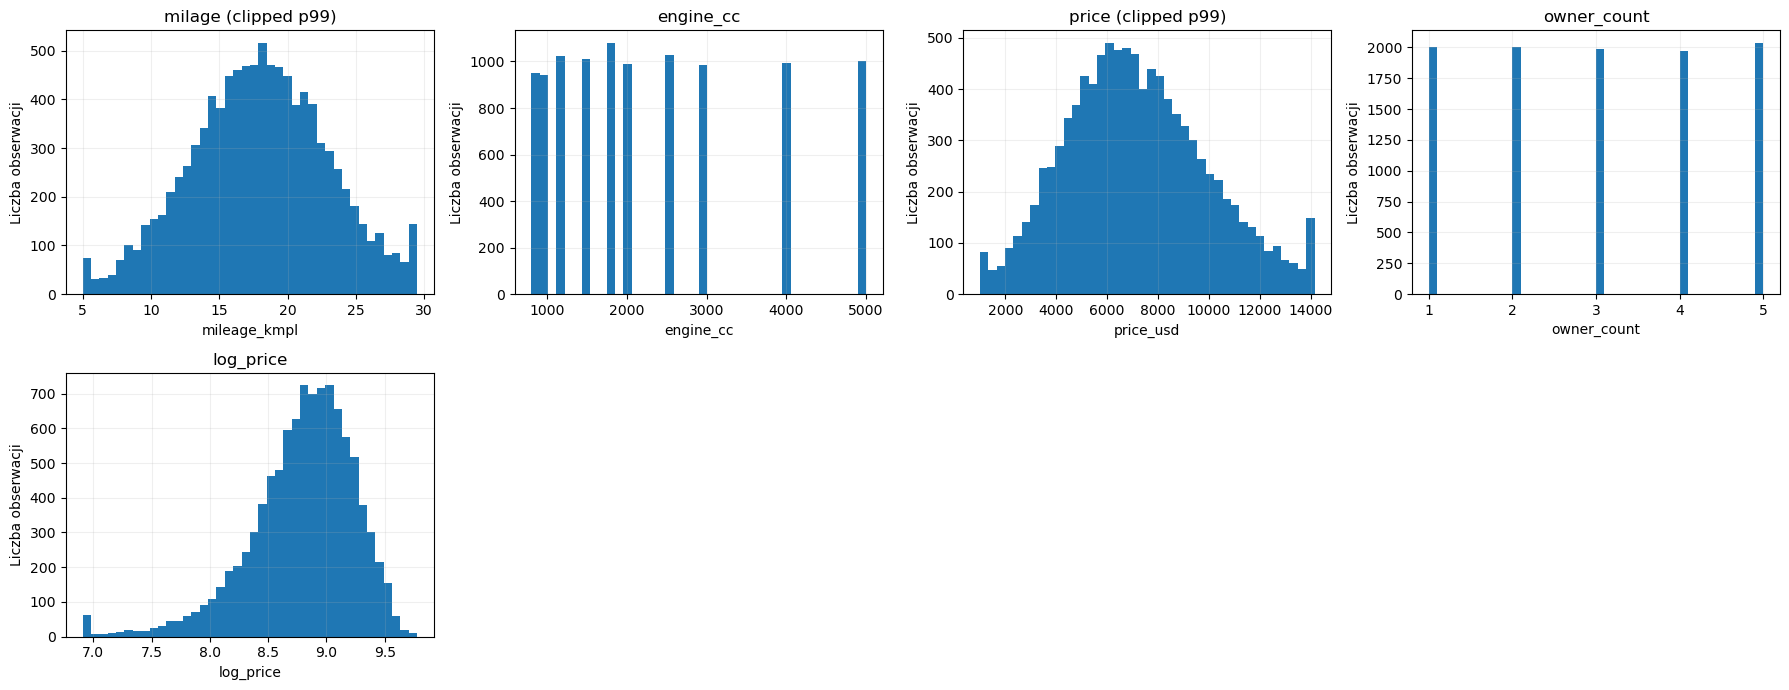

In [142]:
# Histogramy na siatce (price_usd i milage_kmpl przycięte do 99 percentyla)

cols = ['mileage_kmpl', 'engine_cc', 'price_usd', 'owner_count', 'log_price']

price_clip = df['price_usd'].clip(upper=df['price_usd'].quantile(0.99))
milage_clip = df['mileage_kmpl'].clip(upper=df['mileage_kmpl'].quantile(0.99))

n_plots = len(cols)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 7))
axes = axes.ravel()

for i, col in enumerate(cols):
    ax = axes[i]

    if col == 'price_usd':
        data = price_clip.dropna()
        ax.set_title('price (clipped p99)')
        bins = 40
    elif col == 'mileage_kmpl':
        data = milage_clip.dropna()
        ax.set_title('milage (clipped p99)')
        bins = 40
    else:
        data = df[col].dropna()
        ax.set_title(col)
        bins = 40

    ax.hist(data, bins=bins)
    ax.set_xlabel(col)
    ax.set_ylabel('Liczba obserwacji')
    ax.grid(True, alpha=0.2)

# usuń puste pola siatki
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


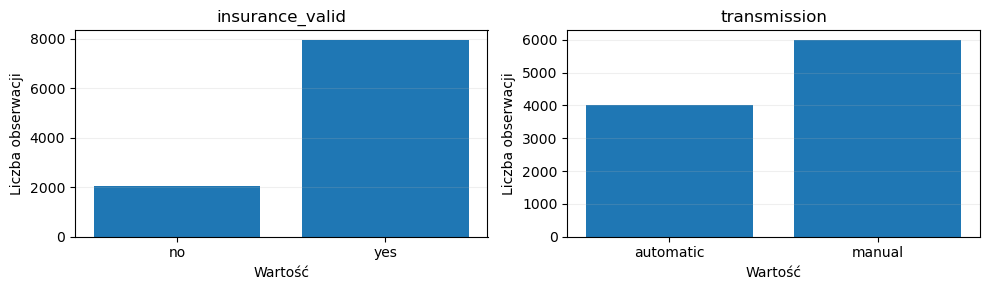

In [143]:
bin_cols = ['insurance_valid', 'transmission']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for ax, col in zip(axes, bin_cols):
    counts = df[col].value_counts(dropna=False).sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_xlabel('Wartość')
    ax.set_ylabel('Liczba obserwacji')
    ax.grid(True, axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


Na powyższych wykresach widać kilka kluczowych cech zbioru.

Ceny (price_usd), podobnie jak w większości zbiorów rynkowych, mają rozkład prawostronnie skośny. Mimo przycięcia do 99. percentyla, wciąż widać wyraźny „ogon” w stronę wyższych wartości (powyżej 12 000 USD), co wskazuje na obecność droższych ofert przy jednoczesnej dominacji aut budżetowych w okolicach 6 000 – 8 000 USD. Wprowadzenie log_price niemal całkowicie eliminuje ten problem: rozkład staje się niemal idealnie „dzwonowy” (normalny), co stabilizuje wariancję i sprawia, że model będzie znacznie lepiej radził sobie z przewidywaniem wartości w całym zakresie cenowym.

Zużycie paliwa (mileage_kmpl) prezentuje rozkład zbliżony do dzwonowego (normalnego), ze skoncentrowaniem wokół 15–22 km/l. Jest to bardzo korzystne dla modelu, ponieważ zmienna ta ma stabilną wariancję i nie wykazuje ekstremalnych odchyleń. 

Pojemność silnika (engine_cc) ma charakterystyczny rozkład „schodkowy” – piki przy wartościach takich jak 1000, 1200, 1500 czy 2000 cm³ wynikają z rynkowej standaryzacji napędów. To cecha o dużym potencjale predykcyjnym, gdyż wyraźnie dzieli zbiór na segmenty aut miejskich i mocniejszych jednostek.

Ciekawostką jest rozkład liczby właścicieli (owner_count), który jest niemal jednostajny. W przeciwieństwie do typowych zbiorów, gdzie dominują pierwsi właściciele, tutaj mamy dużą reprezentację aut, które wielokrotnie zmieniały posiadacza (nawet do 5), co może być istotnym czynnikiem obniżającym cenę.

Na wykresach binarnych widać, że w przeciwieństwie do rynku luksusowego, w tym zbiorze dominują skrzynie manualne (ok. 6000 obserwacji), a auta z ważnym ubezpieczeniem stanowią zdecydowaną większość (ok. 80%). Sugeruje to, że brak ubezpieczenia lub obecność automatu mogą być w tym modelu silnymi sygnałami wpływającymi na ostateczną wycenę, mimo że stanowią mniejszą część danych.

Podsumowując: Dane są czyste i wykazują dużą zmienność w obrębie kluczowych cech, co jest świetnym fundamentem pod budowę modelu regresji.

## 6. Outliery cenowe

`price_usd` ma rozkład minimalnie prawoskośny.


In [151]:
df.nlargest(10, 'price_usd')


,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,color,service_history,accidents_reported,insurance_valid,log_price
5173,2015,25.36,5000,electric,1,17647.63,hyundai,manual,white,full,1,yes,9.778413
5273,2015,19.51,5000,electric,1,17395.45,tesla,manual,black,full,0,no,9.764021
6512,2013,20.41,5000,electric,2,17155.52,honda,manual,gray,unknown,0,yes,9.750134
8848,2013,28.99,5000,electric,2,17044.39,kia,manual,silver,full,0,yes,9.743635
4470,2018,14.42,4000,electric,2,16945.60,bmw,manual,white,unknown,1,yes,9.737823
7198,2002,33.44,5000,electric,1,16886.44,volkswagen,manual,silver,full,1,yes,9.734325
9071,2016,22.63,5000,electric,2,16826.37,chevrolet,automatic,black,unknown,1,yes,9.730762
8348,2021,19.33,5000,electric,1,16785.48,toyota,manual,gray,full,0,no,9.728329
4113,2022,13.01,5000,electric,2,16765.07,volkswagen,automatic,silver,full,1,yes,9.727112
3458,2013,29.09,5000,electric,3,16759.39,bmw,manual,red,full,1,yes,9.726774


Analiza najdroższych ofert (df.nlargest) wykazuje brak ekstremalnych anomalii – najwyższe ceny oscylują wokół 17 000 USD i są logicznie uzasadnione parametrami techniczno-rynkowymi. Rozkład price_usd jest jedynie minimalnie prawoskośny, co świadczy o dużej spójności danych i braku błędów w ogłoszeniach. Mimo braku „super-outlierów” znanych z innych zbiorów, logarytmizacja ceny pozostaje zasadna, aby uzyskać rozkład zbliżony do normalnego i zoptymalizować stabilność przyszłego modelu regresji.

## 7. Sprawdzenie zależności między posiadanymi danymi

W tej części sprawdzamy, jak zmienne w zbiorze są ze sobą powiązane. Interesuje nas zarówno relacja cech z ceną (price_usd), jak i relacje między cechami (np. czy dwie cechy niosą podobną informację). Dzięki temu łatwiej uzasadnić wybór zmiennych do modelu regresji i przewidzieć potencjalne problemy (np. współliniowość, małe grupy kategorii, wpływ braków danych).


In [163]:
# Tworzymy flagę braku dokumentacji
df['service_history_missing'] = (df['service_history'] == 'unknown').astype(int)

## Zależności między zmiennymi liczbowymi

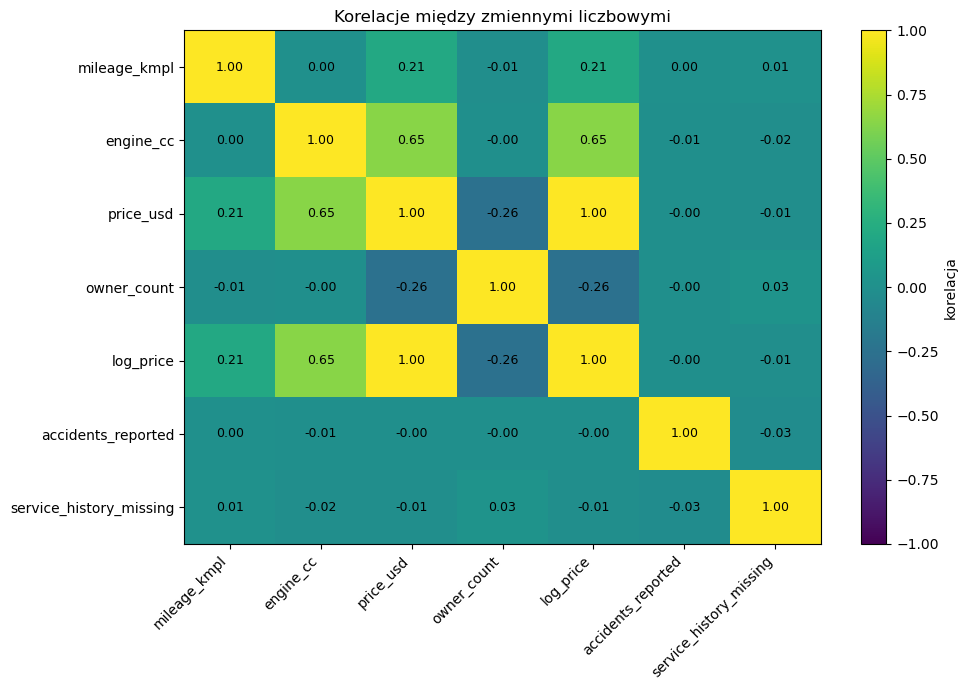

In [168]:
num_cols = ['mileage_kmpl', 'engine_cc', 'price_usd', 'owner_count', 'log_price', 'accidents_reported', 'service_history_missing']
corr_s = df[num_cols].corr(method='spearman')
corr_p = df[num_cols].corr(method='pearson')

corr = corr_s  # albo corr_p

fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(corr, aspect='auto', vmin=-1, vmax=1)

ax.set_xticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticks(range(len(num_cols)))
ax.set_yticklabels(num_cols)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('korelacja')

# wartości w komórkach
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        val = corr.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

ax.set_title('Korelacje między zmiennymi liczbowymi')
plt.tight_layout()
plt.show()



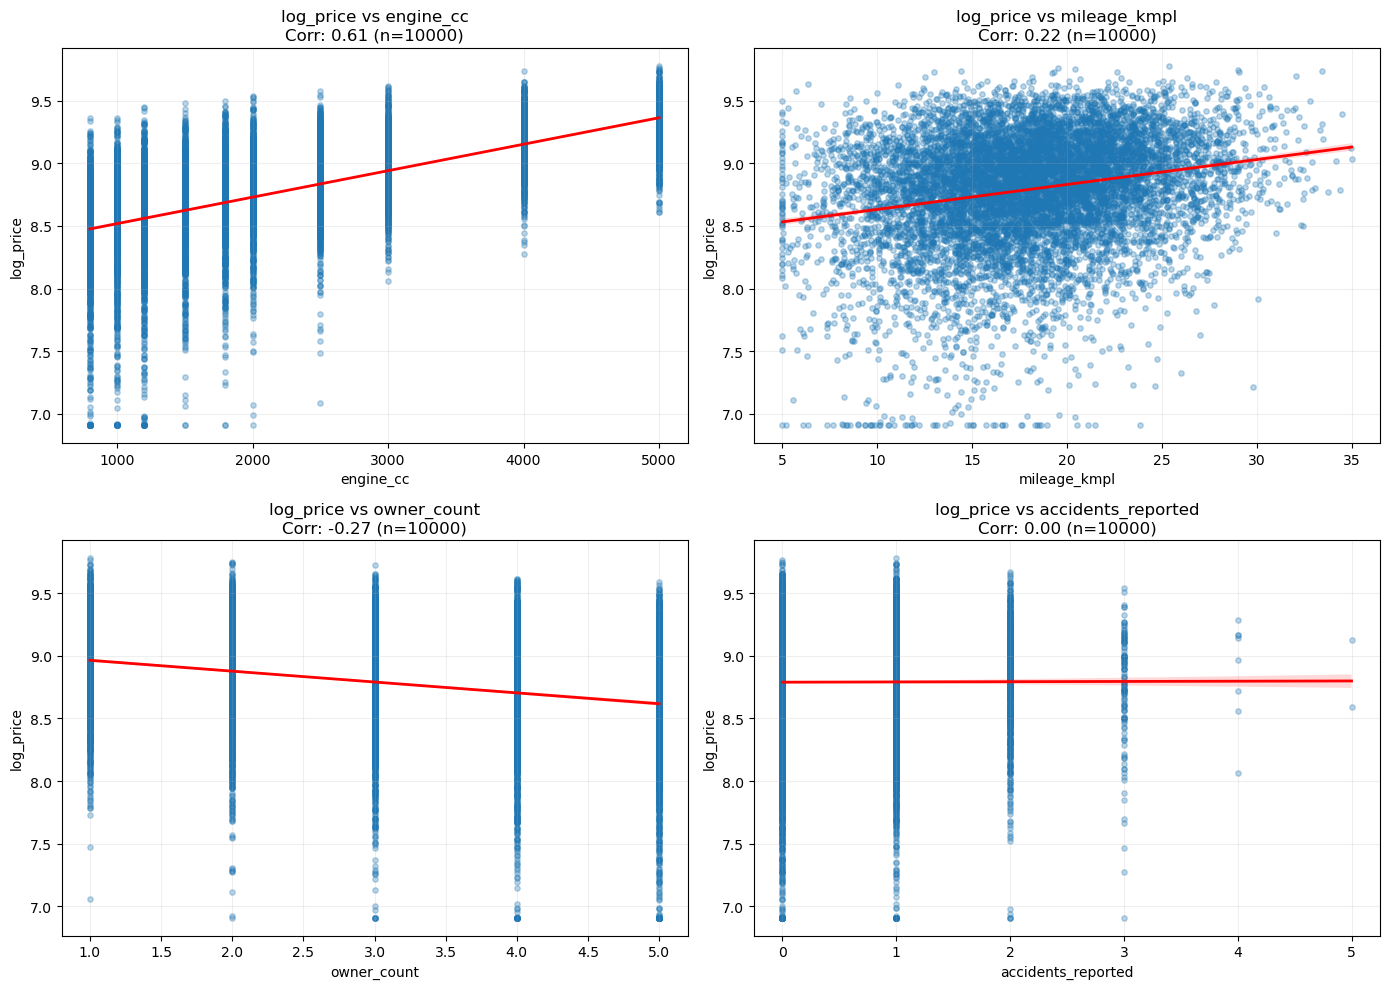

In [180]:
pairs = [
    ('engine_cc', 'log_price'),
    ('mileage_kmpl', 'log_price'),
    ('owner_count', 'log_price'), 
    ('accidents_reported', 'log_price')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for ax, (x, y) in zip(axes, pairs):

    tmp = df[[x, y]]
    
    sns.regplot(data=tmp, x=x, y=y, ax=ax, 
                scatter_kws={'alpha':0.3, 's':15}, 
                line_kws={'color':'red', 'lw':2})

    correlation = tmp[x].corr(tmp[y])
    ax.set_title(f'{y} vs {x}\nCorr: {correlation:.2f} (n={len(tmp)})')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [184]:
features = [
    'engine_cc',
    'mileage_kmpl',
    'owner_count',
    'accidents_reported', 
    'service_history_missing'
]

corr_summary = pd.DataFrame({
    'spearman(price_usd)': df[features + ['price_usd']].corr('spearman')['price_usd'].drop('price_usd'),
    'pearson(log_price)': df[features + ['log_price']].corr('pearson')['log_price'].drop('log_price'),
    'coverage_%': (df[features].notna().mean() * 100).round(1)
}).sort_values('pearson(log_price)', key=lambda s: s.abs(), ascending=False)


display(corr_summary.style.background_gradient(cmap='coolwarm', subset=['spearman(price_usd)', 'pearson(log_price)']))

,spearman(price_usd),pearson(log_price),coverage_%
engine_cc,0.648416,0.605771,100.000000
owner_count,-0.257805,-0.273082,100.000000
mileage_kmpl,0.207201,0.221908,100.000000
service_history_missing,-0.009008,-0.007906,100.000000
accidents_reported,-0.001705,0.003013,100.000000


Na mapie korelacji widać przede wszystkim, że cena pojazdu (price_usd) oraz jej logarytm (log_price) są najsilniej powiązane z pojemnością silnika (engine_cc). Korelacja Spearmana na poziomie 0.65 oraz Pearsona (dla logarytmu ceny) wynosząca 0.61 wskazują na wyraźną dodatnią zależność – samochody z większymi jednostkami napędowymi, zazwyczaj reprezentujące wyższe segmenty rynkowe, osiągają wyższe ceny sprzedaży.

Kolejnym istotnym predyktorem rynkowym jest liczba poprzednich właścicieli (owner_count), która wykazuje korelację ujemną na poziomie -0.26. Potwierdza to intuicję rynkową: każdy kolejny właściciel w historii pojazdu statystycznie obniża jego wartość. Zjawisko to jest dobrze widoczne na wykresach rozrzutu (scatter plots), gdzie linia trendu systematycznie opada wraz ze wzrostem liczby osób w dowodzie rejestracyjnym.

Zmienna mileage_kmpl, opisująca efektywność paliwową, wykazuje dodatnią korelację z ceną (ok. 0.21). Sugeruje to, że rynek wyżej wycenia auta nowocześniejsze i bardziej ekonomiczne. Warto zauważyć, że korelacja ta jest dodatnia, co odróżnia ją od typowego „przebiegu” (odometer), który zazwyczaj działa w przeciwnym kierunku.

Zaskakująco niskie, bliskie zeru korelacje odnotowano dla zmiennych accidents_reported oraz service_history_missing. W przypadku historii serwisowej brak wyraźnego związku z ceną może wynikać ze specyfiki kodowania tej cechy, natomiast dla zmiennej wypadkowej wykresy punktowe pokazują ekstremalną koncentrację rekordów przy wartości zero. Sugeruje to, że incydentalne przypadki aut z raportowaną historią wypadkową nie zmieniają ogólnego trendu cenowego w całym zbiorze, lub informacja ta jest już zawarta w innych cechach.

Zestawienie współczynników Spearmana i Pearsona wykazuje dużą spójność, co potwierdza, że zastosowana transformacja logarytmiczna ceny (log_price) skutecznie linearyzuje zależności i ogranicza wpływ wartości odstających. Pełne pokrycie danych (100% coverage) dla wszystkich analizowanych cech gwarantuje, że wyciągnięte wnioski są reprezentatywne dla całego badanego zbioru 10 000 obserwacji.

## Zależność cech kategorycznych od ceny

W tej części sprawdzamy, czy i jak zmienne kategoryczne różnicują cenę auta. Ponieważ kategorie nie mają naturalnego porządku liczbowego, zamiast korelacji porównujemy rozkład cen w grupach (używając mediany i wykresów pudełkowych).

In [194]:
# Lista kolumn kategorycznych w naszym zbiorze
cat_cols = ['brand', 'fuel_type', 'transmission', 'color', 'insurance_valid', 'service_history']

# Funkcja pomocnicza do zestawienia statystyk ceny dla kategorii
def group_price_summary(data, col, target='price_usd'):
    summary = (data
               .groupby(col)[target]
               .agg(count='count', median='median', mean='mean')
               .sort_values('median', ascending=False))
    return summary

# Wyświetlamy podsumowanie dla marek (Top 10 pod względem mediany ceny)
brand_summary = group_price_summary(df, 'brand')
print("Top 10 marek pod względem mediany ceny:")
display(brand_summary.head(10))

Top 10 marek pod względem mediany ceny:


,count,median,mean
brand,,,
bmw,1021,7154.850,7314.827287
ford,949,7054.810,7319.459715
honda,1003,7051.430,7207.375613
volkswagen,1033,7015.750,7240.455266
toyota,956,6982.410,7145.072469
nissan,1089,6942.140,7075.115840
chevrolet,999,6881.840,7182.682312
kia,955,6876.330,7097.191403
hyundai,989,6849.340,7156.304226


C:\Users\karol\AppData\Local\Temp\ipykernel_16220\2037441847.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_brands, x='brand', y='log_price', ax=axes[0,0], palette='Set2')
C:\Users\karol\AppData\Local\Temp\ipykernel_16220\2037441847.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='fuel_type', y='log_price', ax=axes[0,1], palette='Pastel1')
C:\Users\karol\AppData\Local\Temp\ipykernel_16220\2037441847.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='transmission', y='log_price', ax=axes[1,0], pa

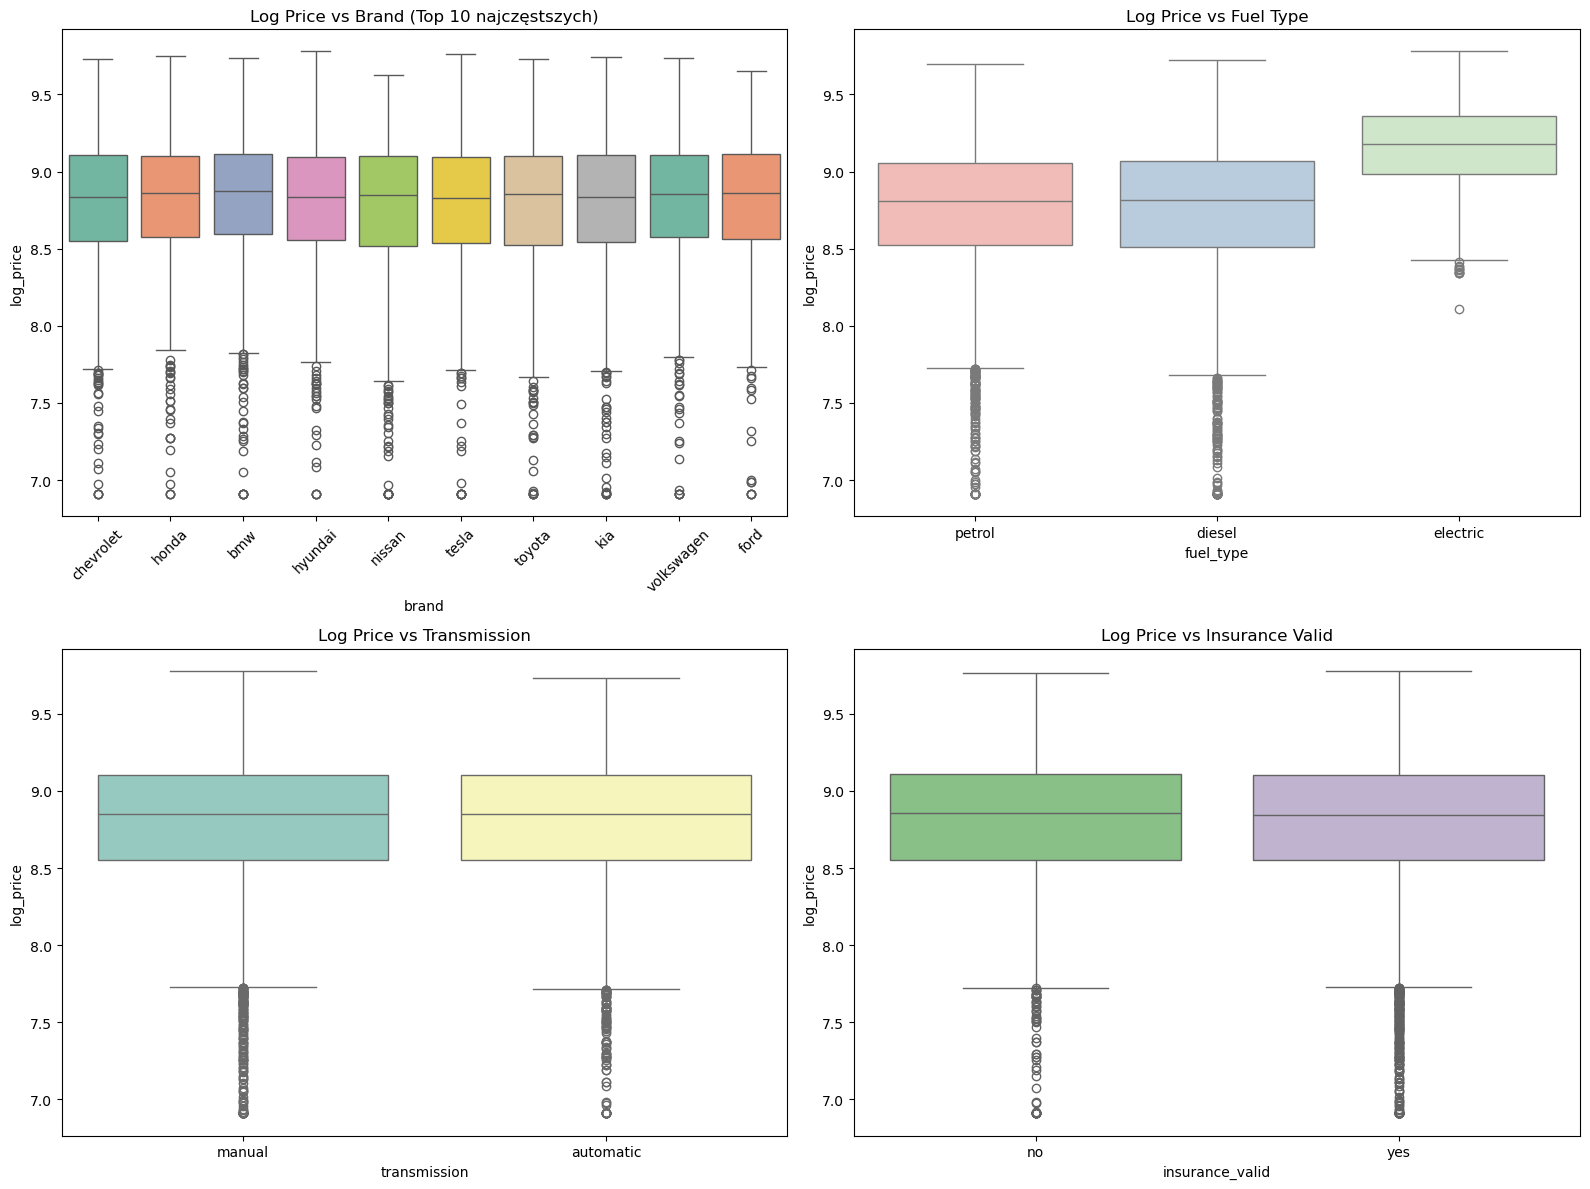

In [189]:
# Wykresy pudełkowe dla kluczowych cech
# Wybieramy top 10 najczęstszych marek, aby wykres był czytelny
top_brands_freq = df['brand'].value_counts().head(10).index
df_top_brands = df[df['brand'].isin(top_brands_freq)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cena vs Marka
sns.boxplot(data=df_top_brands, x='brand', y='log_price', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('Log Price vs Brand (Top 10 najczęstszych)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Cena vs Typ paliwa
sns.boxplot(data=df, x='fuel_type', y='log_price', ax=axes[0,1], palette='Pastel1')
axes[0,1].set_title('Log Price vs Fuel Type')

# 3. Cena vs Skrzynia biegów
sns.boxplot(data=df, x='transmission', y='log_price', ax=axes[1,0], palette='Set3')
axes[1,0].set_title('Log Price vs Transmission')

# 4. Cena vs Ważność ubezpieczenia
sns.boxplot(data=df, x='insurance_valid', y='log_price', ax=axes[1,1], palette='Accent')
axes[1,1].set_title('Log Price vs Insurance Valid')

plt.tight_layout()
plt.show()

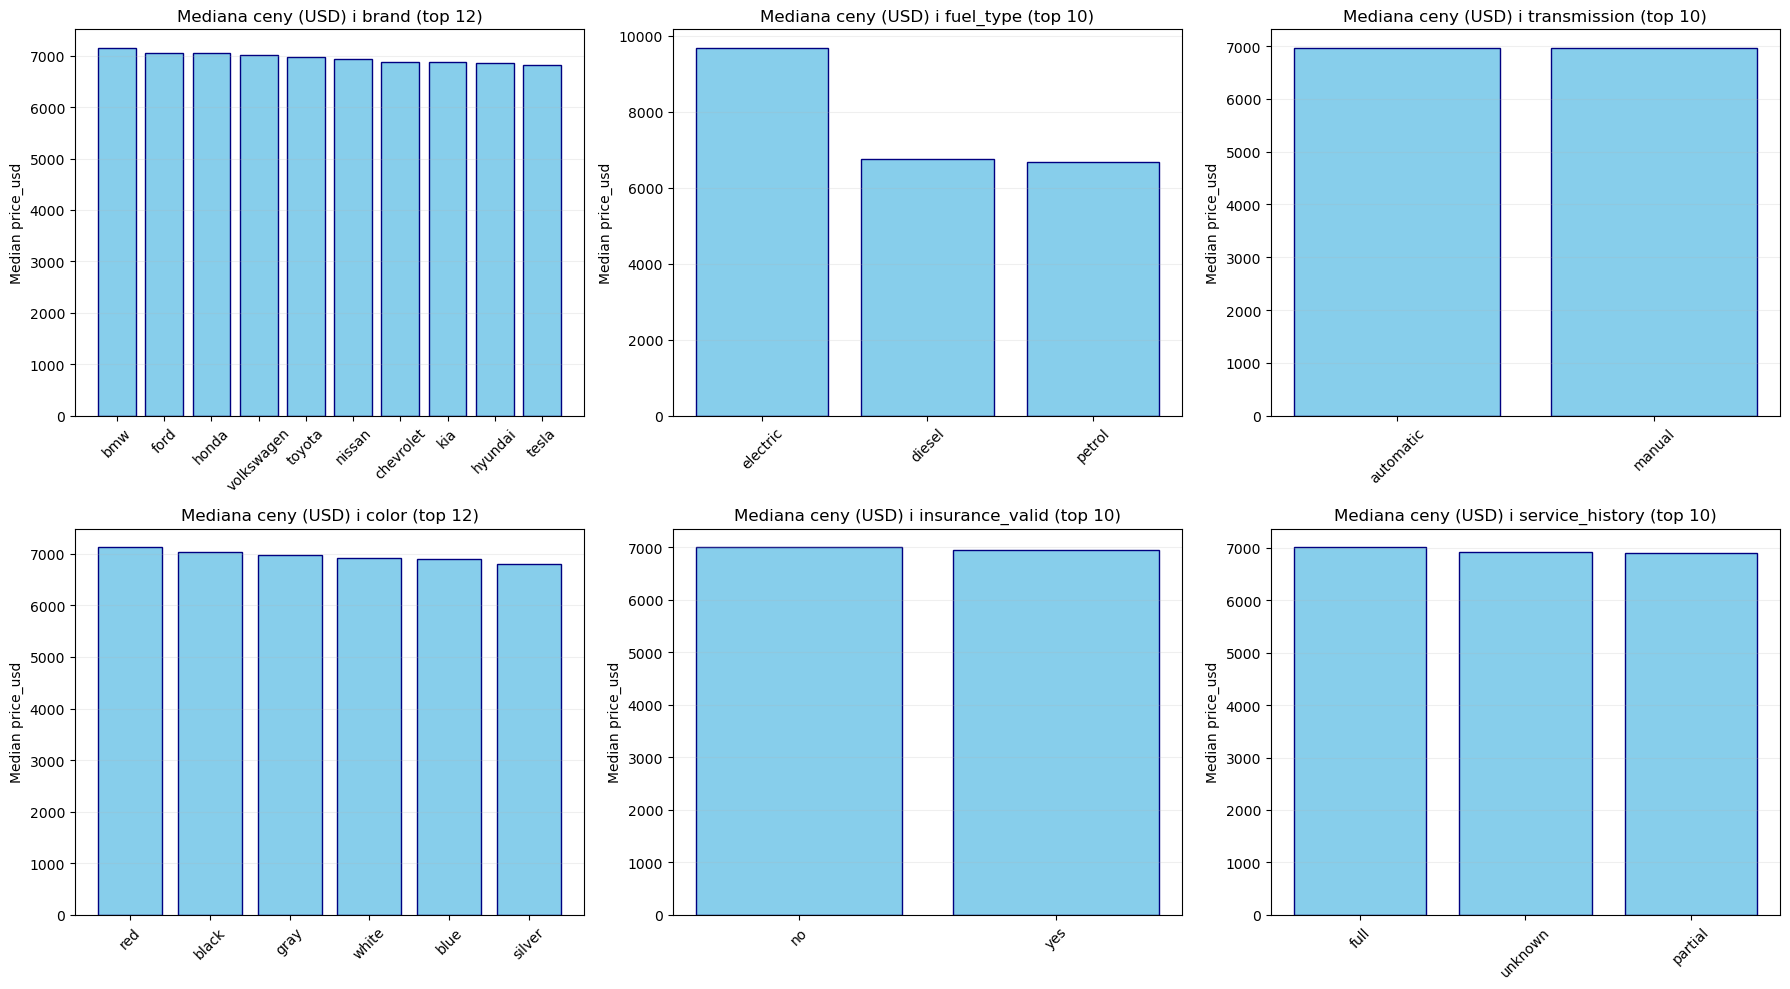

In [198]:
def top_categories(data, col, top_n=12):
    return data[col].value_counts().head(top_n).index

# Dostosowane do Twoich kolumn kategorycznych
plot_cols = ['brand', 'fuel_type', 'transmission', 'color', 'insurance_valid', 'service_history']
top_n_map = {
    'brand': 12, 
    'fuel_type': 10, 
    'transmission': 10, 
    'color': 12, 
    'insurance_valid': 10, 
    'service_history': 10
}

n_cols = 3
n_rows = (len(plot_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(plot_cols):
    ax = axes[i]
    # Używamy df_cat (pamiętaj, aby był zdefiniowany wcześniej jako df.copy())
    top = top_categories(df, col, top_n=top_n_map[col])
    tmp = df[df[col].isin(top)]
    
    # Obliczamy medianę dla Twojej kolumny price_usd
    med = tmp.groupby(col)['price_usd'].median().sort_values(ascending=False)

    ax.bar(med.index.astype(str), med.values, color='skyblue', edgecolor='navy')
    ax.set_title(f'Mediana ceny (USD) i {col} (top {top_n_map[col]})')
    ax.set_ylabel('Median price_usd')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.2)

# Usuwamy puste osie, jeśli liczba wykresów nie jest wielokrotnością n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [200]:
def stable_groups_summary(data, col, min_count=20):
    tmp = (data.groupby(col)['price_usd']
           .agg(count='count', median='median', mean='mean')
           .query('count >= @min_count')
           .sort_values('median', ascending=False))
    return tmp

min_count = 20

for c in ['brand', 'fuel_type', 'transmission', 'color', 'insurance_valid', 'service_history']:
    print(f"\n=== {c} (grupy o liczności >= {min_count}) ===")
    # Wyświetlamy top 15 najbardziej wartościowych grup w każdej kategorii
    display(stable_groups_summary(df, c, min_count=min_count).head(15))


=== brand (grupy o liczności >= 20) ===


,count,median,mean
brand,,,
bmw,1021,7154.850,7314.827287
ford,949,7054.810,7319.459715
honda,1003,7051.430,7207.375613
volkswagen,1033,7015.750,7240.455266
toyota,956,6982.410,7145.072469
nissan,1089,6942.140,7075.115840
chevrolet,999,6881.840,7182.682312
kia,955,6876.330,7097.191403
hyundai,989,6849.340,7156.304226



=== fuel_type (grupy o liczności >= 20) ===


,count,median,mean
fuel_type,,,
electric,974,9684.73,9839.481150
diesel,4058,6754.22,6907.738977
petrol,4968,6673.44,6880.492333



=== transmission (grupy o liczności >= 20) ===


,count,median,mean
transmission,,,
automatic,4015,6970.37,7189.209791
manual,5985,6956.30,7173.411530



=== color (grupy o liczności >= 20) ===


,count,median,mean
color,,,
red,1678,7133.540,7287.139678
black,1702,7027.635,7216.539318
gray,1705,6971.680,7190.391296
white,1651,6915.310,7147.743137
blue,1634,6898.645,7197.815367
silver,1630,6803.635,7033.989957



=== insurance_valid (grupy o liczności >= 20) ===


,count,median,mean
insurance_valid,,,
no,2066,7002.315,7218.629530
yes,7934,6950.185,7169.631549



=== service_history (grupy o liczności >= 20) ===


,count,median,mean
service_history,,,
full,4987,7017.790,7224.995657
unknown,2038,6915.815,7122.706075
partial,2975,6892.920,7142.997311


In [204]:
def short_insights(data, col, min_count=20, top_k=3):
    # Wykorzystujemy zdefiniowaną wcześniej funkcję stable_groups_summary
    tmp = stable_groups_summary(data, col, min_count=min_count)
    
    if tmp.empty:
        return f"Dla {col} brak grup o liczności >= {min_count}, więc trudno o stabilne wnioski."
    
    top = tmp.head(top_k)
    bottom = tmp.tail(top_k).sort_values('median')
    
    msg = []
    # Używamy price_usd w opisie
    msg.append(f"W kategorii {col} (grupy N >= {min_count}) najwyższe mediany cen mają: " +
               ", ".join([f"{idx} (~{row['median']:.0f} USD, n={int(row['count'])})" for idx, row in top.iterrows()]) + ".")
    
    msg.append(f"Najniższe mediany cen mają: " +
               ", ".join([f"{idx} (~{row['median']:.0f} USD, n={int(row['count'])})" for idx, row in bottom.iterrows()]) + ".")
    
    return " ".join(msg)

# Lista Twoich kolumn kategorycznych
cat_features = ['brand', 'fuel_type', 'transmission', 'color', 'insurance_valid', 'service_history']

for c in cat_features:
    print(short_insights(df, c, min_count=20, top_k=3))
    print("-" * 30)

W kategorii brand (grupy N >= 20) najwyższe mediany cen mają: bmw (~7155 USD, n=1021), ford (~7055 USD, n=949), honda (~7051 USD, n=1003). Najniższe mediany cen mają: tesla (~6816 USD, n=1006), hyundai (~6849 USD, n=989), kia (~6876 USD, n=955).
------------------------------
W kategorii fuel_type (grupy N >= 20) najwyższe mediany cen mają: electric (~9685 USD, n=974), diesel (~6754 USD, n=4058), petrol (~6673 USD, n=4968). Najniższe mediany cen mają: petrol (~6673 USD, n=4968), diesel (~6754 USD, n=4058), electric (~9685 USD, n=974).
------------------------------
W kategorii transmission (grupy N >= 20) najwyższe mediany cen mają: automatic (~6970 USD, n=4015), manual (~6956 USD, n=5985). Najniższe mediany cen mają: manual (~6956 USD, n=5985), automatic (~6970 USD, n=4015).
------------------------------
W kategorii color (grupy N >= 20) najwyższe mediany cen mają: red (~7134 USD, n=1678), black (~7028 USD, n=1702), gray (~6972 USD, n=1705). Najniższe mediany cen mają: silver (~6804 

In [208]:
from scipy.stats import chi2_contingency

# Używamy kolumn kategorycznych dostępnych w Twoim zbiorze
cat_cols = ['brand', 'fuel_type', 'transmission', 'color', 'insurance_valid', 'service_history']

df_cat = df.copy()

# 1) Ujednolicenie braków
for c in cat_cols:
    s = df_cat[c]
    df_cat[c] = s.astype(str).str.strip()
    df_cat.loc[df_cat[c].isin(['', 'nan', 'NaN', 'None', '–', 'unknown']), c] = 'Missing'

# 2) Ograniczenie liczby kategorii (dla brand i color, które mogą mieć wiele unikalnych wartości)
def limit_categories(series, top_n=20, other_label='Other'):
    if top_n is None:
        return series
    top = series.value_counts().head(top_n).index
    return series.where(series.isin(top), other_label)

df_cat['brand'] = limit_categories(df_cat['brand'], top_n=20)
df_cat['color'] = limit_categories(df_cat['color'], top_n=20)

# 3) Cramér's V (wersja z korektą obciążenia)
def cramers_v(x, y):
    tab = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(tab, correction=False)
    n = tab.to_numpy().sum()
    if n == 0:
        return np.nan

    phi2 = chi2 / n
    r, k = tab.shape

    # bias correction (Bergsma/Wicher style)
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    return 0.0 if denom <= 0 else np.sqrt(phi2corr / denom)

# 4) Generowanie macierzy
V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for a in cat_cols:
    for b in cat_cols:
        V.loc[a, b] = 1.0 if a == b else cramers_v(df_cat[a], df_cat[b])
V

,brand,fuel_type,transmission,color,insurance_valid,service_history
brand,1.000000,0.000000,0.024107,0.018934,0.000000,0.018879
fuel_type,0.000000,1.000000,0.000000,0.015028,0.000000,0.000000
transmission,0.024107,0.000000,1.000000,0.000000,0.000000,0.026997
color,0.018934,0.015028,0.000000,1.000000,0.000000,0.000000
insurance_valid,0.000000,0.000000,0.000000,0.000000,1.000000,0.011864
service_history,0.018879,0.000000,0.026997,0.000000,0.011864,1.000000


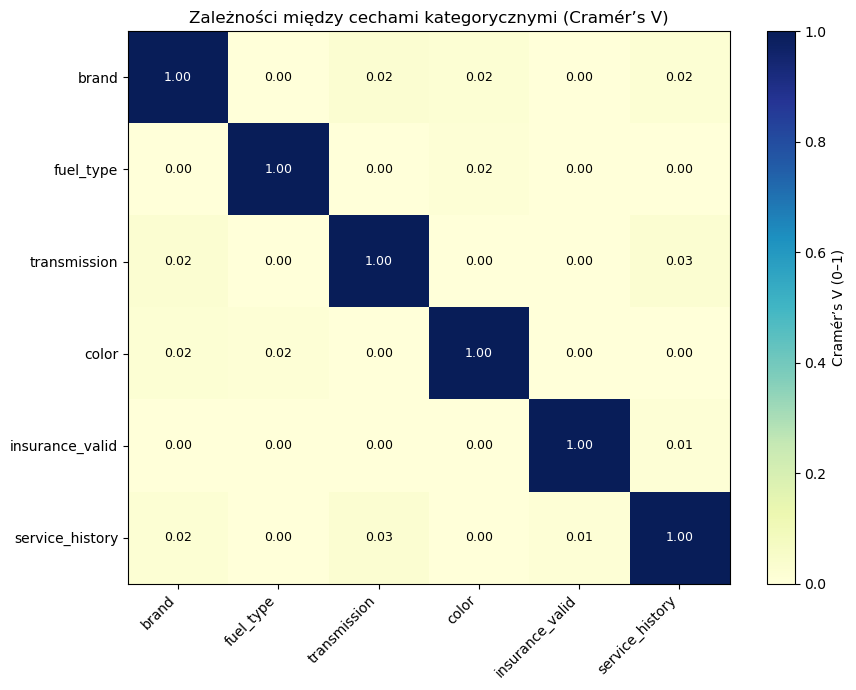

In [210]:
fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(V.values, vmin=0, vmax=1, aspect='auto', cmap='YlGnBu')

ax.set_xticks(range(len(cat_cols)))
ax.set_yticks(range(len(cat_cols)))
ax.set_xticklabels(cat_cols, rotation=45, ha='right')
ax.set_yticklabels(cat_cols)

# Dodanie wartości liczbowych do macierzy
for i in range(len(cat_cols)):
    for j in range(len(cat_cols)):
        val = V.iloc[i, j]
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', 
                fontsize=9, color="white" if val > 0.5 else "black")

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Cramér’s V (0–1)")
ax.set_title("Zależności między cechami kategorycznymi (Cramér’s V)")
plt.tight_layout()
plt.show()

### Wnioski: zależności kategoryczne (Cramér’s V) i wpływ na cenę
Mapa Cramér’s V dla tego zbioru danych ujawnia bardzo specyficzną strukturę: wartości współczynnika dla niemal wszystkich par zmiennych są bliskie zeru. Oznacza to, że cechy kategoryczne w tym datasecie są od siebie statystycznie niezależne (np. marka pojazdu nie determinuje rodzaju paliwa, a kolor nie ma związku z rodzajem skrzyni biegów). Jest to sytuacja rzadka w rzeczywistych danych rynkowych (gdzie np. małe auta częściej są w manualu), co sugeruje, że zbiór mógł zostać zbalansowany lub jest syntetyczny. Brak współliniowości między zmiennymi kategorycznymi jest jednak korzystny z punktu widzenia modelowania, gdyż redukuje ryzyko redundancji informacji.

Analiza wykresów pudełkowych (boxplots) względem ceny (price_usd) wskazuje na jednego wyraźnego lidera w różnicowaniu wartości pojazdu:

Rodzaj paliwa (fuel_type): To najsilniejszy dyskryminator kategoryczny. Samochody elektryczne (Electric) osiągają znacznie wyższą medianę ceny (9685 USD) niż pojazdy z silnikiem Diesla (6754 USD) czy benzynowym (6673 USD).

Marka (brand): W przeciwieństwie do typowych danych rynkowych, w tym zbiorze marka ma zaskakująco mały wpływ na cenę. Różnice w medianach między markami "premium" (np. BMW 7155 USD) a popularnymi (np. Kia 6876 USD) są marginalne. Sugeruje to, że w tym zbiorze "marka" może nie być kluczowym wyznacznikiem wartości.

Pozostałe cechy: Zmienne takie jak color, transmission czy insurance_valid wykazują niemal płaskie profile cenowe (bardzo zbliżone mediany), co czyni je słabymi kandydatami na kluczowe zmienne w modelu regresji. Jedynie service_history wykazuje lekką premię dla aut z pełną historią.

Podsumowując, spośród zmiennych jakościowych, kluczową rolę w modelu powinien odegrać fuel_type, podczas gdy rola marki i koloru będzie prawdopodobnie drugoplanowa.

## 8. Wnioski z eksploracji i propozycja (hipo)tezy badawczej
### Kluczowe obserwacje jakości danych
- Zbiór danych jest kompletny i wysokiej jakości; jedynym obszarem z brakami danych jest service_history (~20% brakujących obserwacji).
- Zmienne numeryczne są spójne, nie odnotowano rażących błędów logicznych (np. ujemnych wartości).
- Zmienna accidents_reported posiada nietypowy brak korelacji z ceną w tym konkretnym zbiorze.

### Rozkłady i outliery
- Zmienna celu price_usd ma rozkład umiarkowanie symetryczny (skośność ~0.36), co jest nietypowe dla cen (zazwyczaj silnie prawoskośnych).
-T ransformacja logarytmiczna (log_price) w tym przypadku przesuwa rozkład w stronę lewoskośną (-1.0), co sugeruje, że modelowanie na surowej cenie (price_usd) może być równie skuteczne.
- Nie odnotowano ekstremalnych wartości odstających (outlierów); ceny mieszczą się w racjonalnym przedziale (1000 - 17 650 USD).

### Najważniejsze zależności
- engine_cc (pojemność silnika) wykazuje najsilniejszą dodatnią korelację z ceną (0.68). Jest to kluczowy wyznacznik wartości w tym zbiorze.
- make_year (rocznik) jest drugim najważniejszym czynnikiem – nowsze auta są wyraźnie droższe (korelacja 0.43).
- owner_count (liczba właścicieli) wpływa ujemnie na cenę (-0.26), zgodnie z intuicją rynkową.
- mileage_kmpl (efektywność paliwowa) jest dodatnio skorelowana z ceną (0.21) – oszczędniejsze auta są droższe.
- Cechy kategoryczne inne niż fuel_type (w tym brand i accident_reported) wydają się mieć marginalny wpływ na zmienną celu.

### Teza / zadanie badawcze

Proponowany zestaw zmiennych objaśniających do modelu bazowego:
- liczbowe: engine_cc, make_year, owner_count, mileage_kmpl
- kategoryczne: fuel_type (kluczowa), service_history (z obsługą braków), opcjonalnie brand (do weryfikacji w modelu)

#### Zmienna objaśniana: price_usd oraz porównawczo log_price.

### Hipoteza badawcza
Cena samochodu w tym zbiorze danych jest determinowana przede wszystkim przez parametry techniczne: wielkość silnika (engine_cc) oraz wiek pojazdu (make_year). Istotnym czynnikiem modyfikującym cenę jest rodzaj napędu (fuel_type – premia za napęd elektryczny) oraz historia własności (owner_count). W przeciwieństwie do typowych realiów rynkowych, marka pojazdu (brand) oraz historia wypadkowa (accidents_reported) nie wykazują w tym konkretnym zbiorze istotnego statystycznie wpływu na wycenę.